In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Create the maze environment
maze = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])
MAZE_SIZE = maze.shape[0]

# Start, sub-goal, and end goal positions
start_position = (1, 1)
sub_goal_position = (5, 3)
end_goal_position = (7, 8)

# Actions the agent can take: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


In [31]:
gamma = 0.8         # Discount factor
alpha_actor = 0.5   # Actor learning rate
alpha_critic = 0.5  # Critic learning rate
epsilon = 0.5       # Exploration rate
episodes = 2000     # Number of episodes
max_steps = 200     # Max steps per episode

# Initialize value function (critic) and policy (actor)
V = np.zeros((MAZE_SIZE, MAZE_SIZE, 2))  # State-value function
policy = np.ones((MAZE_SIZE, MAZE_SIZE, len(actions))) / len(actions)  # Initial uniform policy

# Reward matrix setup
reward_matrix = np.full(maze.shape, -1.0)  # Negative reward for each step
reward_matrix[sub_goal_position] = 10.0    # Reward for reaching sub-goal
reward_matrix[end_goal_position] = 500.0   # Reward for reaching end goal

# Variables to track evaluation metrics
success_count = 0
total_rewards = 0
total_steps_to_sub_goal = 0
total_steps_to_end_goal = 0
successful_episodes = 0
learning_rates = []
convergence_episodes = []

# Arrays to track learning curve
rewards_per_episode = []
success_rate_per_episode = []

# Function to choose the next action using epsilon-greedy policy
def epsilon_greedy(state):
    if np.random.rand() < epsilon:
        return np.random.randint(len(actions))  # Explore
    else:
        return np.argmax(policy[state[0], state[1]])  # Exploit

# Function to run Actor-Critic learning
def actor_critic():
    global success_count, total_rewards, total_steps_to_sub_goal, total_steps_to_end_goal, successful_episodes
    
    for episode in range(episodes):
        state = (start_position[0], start_position[1], False)
        visited_states = set()
        episode_reward = 0
        steps_taken = 0
        sub_goal_steps = 0
        
        subgoal_reached = False

        for step in range(max_steps):
            action_idx = epsilon_greedy(state)
            action = actions[action_idx]
            next_x = state[0] + action[0]
            next_y = state[1] + action[1]
            
            # Check if next_state is within bounds and not a wall
            if 0 <= next_x < MAZE_SIZE and 0 <= next_y < MAZE_SIZE and maze[next_x, next_y] == 0:
                
                # Prevent going back to previous states if subgoal is reached
                if subgoal_reached and (next_x, next_y) in visited_states:
                    reward = -100
                else:
                    visited_states.add((next_x, next_y))
                    reward = reward_matrix[next_x, next_y]
                    episode_reward += reward

                    # If sub-goal is reached
                    if (next_x, next_y) == sub_goal_position and not subgoal_reached:
                        subgoal_reached = True
                        reward = 10.0
                        sub_goal_steps = steps_taken + 1
                        total_steps_to_sub_goal += sub_goal_steps

                    # If end goal is reached
                    if (next_x, next_y) == end_goal_position:
                        if subgoal_reached:
                            reward = 500.0
                            success_count += 1
                            successful_episodes += 1
                            total_steps_to_end_goal += steps_taken + 1
                            convergence_episodes.append(episode)
                            break
                        else:
                            reward = -100.0   # Penalty for trying to reach end goal before sub-goal

                # Actor-Critic update rule
                best_next_action = np.argmax(policy[next_x, next_y])
                td_target = reward + gamma * V[next_x, next_y, int(subgoal_reached)]
                td_delta = td_target - V[state[0], state[1], int(subgoal_reached)]
                
                # Update value function (critic)
                V[state[0], state[1], int(subgoal_reached)] += alpha_critic * td_delta
                
                # Update policy (actor)
                policy[state[0], state[1], action_idx] += alpha_actor * td_delta
                policy[state[0], state[1]] /= np.sum(policy[state[0], state[1]])  # Normalize policy
                
                state = (next_x, next_y, subgoal_reached)
                steps_taken += 1
                
                # End episode if end goal is reached after sub-goal
                if (next_x, next_y) == end_goal_position and subgoal_reached:
                    break
            else:
                # Penalize hitting a wall or moving out of bounds
                V[state[0], state[1], int(subgoal_reached)] += alpha_critic * (-100 + gamma * 0 - V[state[0], state[1], int(subgoal_reached)])
                
        total_rewards += episode_reward
        rewards_per_episode.append(episode_reward)
        success_rate_per_episode.append(success_count / (episode + 1))
        if (episode + 1) % 100 == 0:
            print(f'Episode {episode + 1}/{episodes} completed.')

actor_critic()  # Calculate evaluation metrics


Episode 100/2000 completed.
Episode 200/2000 completed.
Episode 300/2000 completed.
Episode 400/2000 completed.
Episode 500/2000 completed.
Episode 600/2000 completed.
Episode 700/2000 completed.
Episode 800/2000 completed.
Episode 900/2000 completed.
Episode 1000/2000 completed.
Episode 1100/2000 completed.
Episode 1200/2000 completed.
Episode 1300/2000 completed.
Episode 1400/2000 completed.
Episode 1500/2000 completed.
Episode 1600/2000 completed.
Episode 1700/2000 completed.
Episode 1800/2000 completed.
Episode 1900/2000 completed.
Episode 2000/2000 completed.


In [32]:
success_rate = success_count / episodes
average_reward = total_rewards / episodes
average_steps_to_sub_goal = total_steps_to_sub_goal / successful_episodes if successful_episodes > 0 else 0
average_steps_to_end_goal = total_steps_to_end_goal / successful_episodes if successful_episodes > 0 else 0
average_convergence_speed = np.mean(convergence_episodes) if convergence_episodes else 0
average_learning_rate = np.mean(learning_rates)

# Print evaluation results
print(f'Success Rate: {success_rate * 100:.2f}%')
print(f'Average Reward: {average_reward:.2f}')
print(f'Average Steps to Sub-Goal: {average_steps_to_sub_goal:.2f}')
print(f'Average Steps to End-Goal: {average_steps_to_end_goal:.2f}')
print(f'Average Convergence Speed: {average_convergence_speed:.2f}')
print(f'Average Learning Rate: {average_learning_rate:.6f}')


Success Rate: 13.35%
Average Reward: 446.06
Average Steps to Sub-Goal: 201.08
Average Steps to End-Goal: 76.26
Average Convergence Speed: 1072.27
Average Learning Rate: nan


/Users/tuanadurmayuksel/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tuanadurmayuksel/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [33]:

# Function to extract the optimal path from start to goal
def extract_ac_path(start, goal):
    state = (start[0], start[1], False)
    path = [state[:2]]
    
    for step in range(max_steps):
        action_idx = np.argmax(policy[state[0], state[1]])
        action = actions[action_idx]
        next_x = state[0] + action[0]
        next_y = state[1] + action[1]
        subgoal_reached = state[2]
        
        if 0 <= next_x < MAZE_SIZE and 0 <= next_y < MAZE_SIZE and maze[next_x, next_y] == 0:
            if (next_x, next_y) == sub_goal_position:
                subgoal_reached = True
            state = (next_x, next_y, subgoal_reached)
            path.append((next_x, next_y))
        else:
            break  # Invalid move, stop the path
        
        if (next_x, next_y) == goal and subgoal_reached:
            break
    
    return path

# Get the optimal path from start to end goal
optimal_path = extract_ac_path(start_position, end_goal_position)
print("Optimal Path:", optimal_path)

Optimal Path: [(1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (5, 4), (5, 3), (

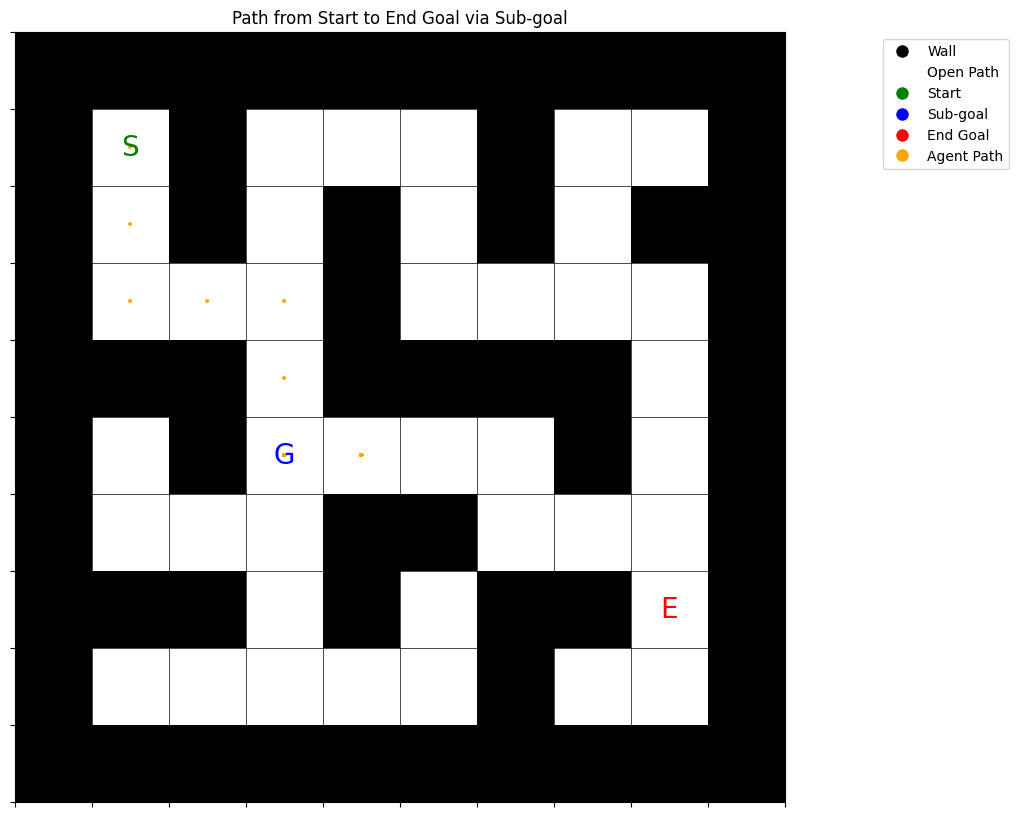

In [34]:

# Function to visualize the agent's path
def visualize_path(path, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap="gray_r")
    for (x, y) in path:
        plt.text(y, x, '•', color='orange', ha='center', va='center', fontsize=10)
    plt.text(start_position[1], start_position[0], 'S', color='green', ha='center', va='center', fontsize=20)
    plt.text(sub_goal_position[1], sub_goal_position[0], 'G', color='blue', ha='center', va='center', fontsize=20)
    plt.text(end_goal_position[1], end_goal_position[0], 'E', color='red', ha='center', va='center', fontsize=20)
    plt.title(title)
    plt.grid(True, which='both', color='black', linewidth=0.5)
    plt.xticks(np.arange(-.5, MAZE_SIZE, 1), [])
    plt.yticks(np.arange(-.5, MAZE_SIZE, 1), [])
    
    # Legend/map for a better visualization
    labels = ['Wall', 'Open Path', 'Start', 'Sub-goal', 'End Goal', 'Agent Path']
    colors = ['black', 'white', 'green', 'blue', 'red', 'orange']
    patches = []

    # Loop through each label and color to create legend symbols
    for i in range(len(labels)):
        label = labels[i]
        color = colors[i]
        
        # Create legend symbols using a small circle marker with the label and color
        patch = plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
        patches.append(patch)

    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.3, 1))
    
    plt.show()

visualize_path(optimal_path, "Path from Start to End Goal via Sub-goal")

steps_to_sub_goal = optimal_path.index(sub_goal_position) + 1 if sub_goal_position in optimal_path else None
steps_to_end_goal = len(optimal_path)


